In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import  RandomizedSearchCV
from scipy.stats import uniform, randint

In [172]:
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

In [173]:
seasons_df=pd.read_pickle('data/seasons_betting_constants_df.pkl')

In [174]:
seasons_df['season'].value_counts()

season
season09    552
season10    552
season11    552
season12    552
season13    552
season14    552
season15    552
season16    552
season17    552
season18    552
season19    552
season20    552
season21    552
season22    552
season23    552
Name: count, dtype: int64

In [175]:
seasons_df['Date'].is_monotonic_increasing

True

In [176]:
seasons_df.drop(columns=['HomeTeam','AwayTeam'], inplace=True)

In [177]:
pd.set_option('future.no_silent_downcasting', True)
seasons_df=seasons_df.fillna(0)

In [178]:
seasons_df

,Date,FTR,home.matchNumber,away.matchNumber,season,B365H,B365D,B365A,MaxH,AvgH,MaxD,AvgD,MaxA,AvgA,diff.daysSince,diff.total.win,diff.total.draw,diff.total.loss,diff.total.goals,diff.total.conceded,diff.total.half_goals,diff.total.half_conceded,diff.total.shots,diff.total.shots_against,diff.total.shots_target,diff.total.shots_against_target,diff.total.corners,diff.total.corners_conceded,diff.total.fouls,diff.total.fouls_other_team,diff.total.yellows,diff.total.reds,diff.last3.win,diff.last3.draw,diff.last3.loss,diff.last3.goals,diff.last3.conceded,diff.last3.half_goals,diff.last3.half_conceded,diff.last3.shots,diff.last3.shots_against,diff.last3.shots_target,diff.last3.shots_against_target,diff.last3.corners,diff.last3.corners_conceded,diff.last3.fouls,diff.last3.fouls_other_team,diff.last3.yellows,diff.last3.reds,diff.total.win.whenHorA,diff.total.draw.whenHorA,diff.total.loss.whenHorA,diff.grade,diff.grade2,diff.Balance,diff.TotArrivals
0,2009-08-07,D,1,1,season09,2.25,3.25,3.20,2.43,2.23,3.40,3.21,3.50,3.13,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16.0,-29980000.0,-3
1,2009-08-08,H,1,1,season09,1.67,3.60,5.25,1.73,1.66,3.81,3.48,5.61,5.08,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,11.0,585000.0,2
2,2009-08-08,D,1,1,season09,1.91,3.30,4.20,1.97,1.88,3.46,3.29,4.48,3.99,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,5.0,-25000.0,8
3,2009-08-08,H,1,1,season09,2.00,3.30,3.80,2.10,1.97,3.42,3.27,4.00,3.67,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,50.0,-2910000.0,-5
4,2009-08-08,H,1,1,season09,2.25,3.25,3.20,2.30,2.21,3.31,3.22,3.53,3.10,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-17,3.0,1385000.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,2024-05-04,H,46,46,season23,3.40,3.40,2.20,3.50,3.40,3.45,3.35,2.23,2.16,0.0,-0.333333,0.155556,0.177778,-0.422222,0.488889,-0.222222,0.288889,-2.711111,2.8,-1.511111,1.688889,-0.822222,1.866667,1.777778,-0.933333,0.0,0.066667,-0.333333,0.333333,0.0,-1.333333,-1.666667,-0.333333,-1.0,-4.333333,-4.333333,-3.0,-3.0,-0.666667,3.333333,3.0,-0.666667,2.0,0.0,-0.227273,0.272727,-0.045455,2,-8.0,930000.0,-8
8276,2024-05-04,H,46,46,season23,2.05,3.40,3.75,2.10,2.05,3.70,3.52,3.75,3.51,0.0,-0.066667,0.0,0.066667,-0.177778,0.288889,0.0,0.288889,0.688889,-0.577778,-0.2,0.177778,0.622222,-0.155556,2.866667,-0.711111,0.844444,0.044444,0.333333,-0.333333,0.0,0.333333,-0.333333,0.666667,0.0,3.666667,2.666667,0.333333,0.0,-2.0,1.333333,9.0,-5.666667,1.333333,0.0,0.045455,-0.045455,0.0,-2,3.0,31540000.0,7
8277,2024-05-04,A,46,46,season23,2.70,3.40,2.55,2.87,2.73,3.40,3.25,2.80,2.62,0.0,0.044444,0.0,-0.044444,0.222222,-0.355556,0.177778,-0.111111,3.244444,-1.644444,1.444444,-0.133333,0.688889,-0.755556,-2.044444,2.822222,-0.177778,-0.066667,-0.333333,-0.333333,0.666667,-2.0,0.0,-0.333333,-0.333333,-2.0,-5.333333,-1.666667,-2.0,1.0,-3.666667,1.333333,0.0,0.0,0.0,0.181818,0.045455,-0.227273,21,-1.0,-3090000.0,-3
8278,2024-05-04,A,46,46,season23,2.05,3.50,3.60,2.07,2.04,3.61,3.50,3.76,3.57,0.0,0.0,0.022222,-0.022222,0.333333,0.2,0.111111,0.111111,1.044444,1.177778,0.266667,0.933333,0.911111,-0.711111,-2.466667,2.844444,-0.288889,0.044444,-0.333333,0.333333,0.0,0.666667,0.333333,-0.333333,0.333333,6.0,3.666667,2.0,0.0,2.0,-2.666667,-0.333333,3.666667,0.333333,0.0,0.090909,-0.045455,-0.045455,-2,-6.0,-18240000.0,-3


In [179]:
label_encoder = LabelEncoder()
seasons_df['label'] = label_encoder.fit_transform(seasons_df['FTR'])

In [180]:
train = seasons_df[~seasons_df['season'].isin([ 'season19','season23'])]

train=train.copy()
train.drop(['Date','season'], axis=1, inplace=True)
train_columns=train.columns

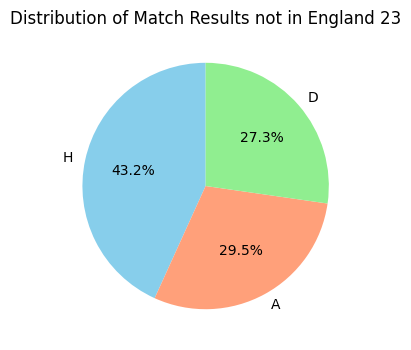

In [181]:
# Calculate value counts for 'result' column
result_counts = train['FTR'].value_counts()

# Define the colors in the same order as the labels
color_mapping = {'A': '#FFA07A',  # Light salmon (matte orange)
                 'H': '#87CEEB',  # Sky blue (matte blue)
                 'D': '#90EE90'}  # Light green (matte green)
colors = [color_mapping[label] for label in result_counts.index]

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results not in England 23")
plt.show()


In [182]:
X_train=train.drop(['label','FTR'], axis=1)
y_train=train['label']

In [183]:
train_columns=X_train.columns

In [184]:
test=seasons_df[(seasons_df['season'].isin(['season23']))]
test=test.copy()
test.drop('season', axis=1, inplace=True)

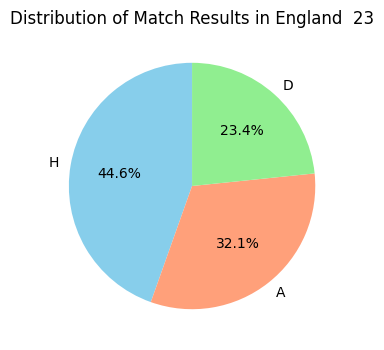

In [185]:
# Calculate value counts for 'result' column
result_counts = test['FTR'].value_counts()

# Define the colors in the same order as the labels
color_mapping = {'A': '#FFA07A',  # Light salmon (matte orange)
                 'H': '#87CEEB',  # Sky blue (matte blue)
                 'D': '#90EE90'}  # Light green (matte green)
colors = [color_mapping[label] for label in result_counts.index]

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results in England  23")
plt.show()


In [186]:
test=test.drop([ 'FTR'], axis=1)
y_test=test['label']

In [187]:
len(y_test)

552

### Scale the features

In [188]:
scaling_columns=X_train.columns

In [189]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


In [190]:
test=test.copy()
test[scaling_columns]=scaler.transform(test[scaling_columns])

### Looping through each date and incrementally train and predict

In [191]:
best_params = {
    'colsample_bytree': 0.60,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 5,
    'n_estimators': 400,
    'gamma': 0.4, # low value means more splits
    'reg_alpha': 0.37, # higher values reduce over fitting
    'reg_lambda': 0.79, # higher values reduce over fittin
    'subsample': 0.25
}

model = xgb.XGBClassifier(**best_params)

In [192]:
best_params = {
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 100
}

model = xgb.XGBClassifier(**best_params)

In [193]:
model = xgb.XGBClassifier(
    colsample_bytree=0.795446471594121,
    gamma=0.3387821809211412,
    learning_rate=0.014976348678356847,
    max_depth=5,
    min_child_weight=3,
    n_estimators=247,
    reg_alpha=0.6451727904094499,
    reg_lambda=0.17436642900499144,
    subsample=0.845468869051233,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'  # Recommended for classification tasks
)

In [194]:
# Initialize model and train on initial training data
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.795446471594121, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.3387821809211412, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.014976348678356847,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=247, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [195]:
test = test.sort_values('Date')
unique_dates = test['Date'].unique()

In [196]:
%%time
#Wall time: 2min 6s

predictions = []
probabilities = []
accuracies =  []
batchsizes = []
acc_batch = []


test_batches_with_predictions = []

for date in unique_dates:
    # Filter test data for the current date
    test_batch = test[test['Date'] == date].copy()
    X_test_batch = test_batch.drop(columns=['label', 'Date'])
    y_test_batch = test_batch['label']
    
    # Make predictions and get probabilities for the current batch
    y_pred_batch = model.predict(X_test_batch)
    y_proba_batch = model.predict_proba(X_test_batch)  # Get probabilities
    probabilities.extend(y_proba_batch)

    # Add predictions and probabilities to the test batch
    test_batch['predictions'] = y_pred_batch
    proba_df = pd.DataFrame(
        y_proba_batch, 
        columns=[f'proba_{class_name}' for class_name in label_encoder.classes_]
    )

    test_batch = pd.concat([test_batch.reset_index(drop=True), proba_df.reset_index(drop=True)], axis=1)

    test_batches_with_predictions.append(test_batch)
    
    # collect metrics
    predictions.extend(y_pred_batch)
    probabilities.extend(y_proba_batch)
    accuracies.append(accuracy_score(y_test_batch, y_pred_batch))
    batchsizes.append( len(X_test_batch))
    acc_batch.append(accuracy_score(y_test_batch, y_pred_batch) * len(X_test_batch))
    
    # Calculate and display metrics if desired (e.g., accuracy for this batch)
    print(f"Date: {date} - Accuracy: {accuracy_score(y_test_batch, y_pred_batch):.4f} - BatchSize: {len(X_test_batch)}")

    
    # Update model with the current batch
    X_all=np.concatenate([X_train, X_test_batch.to_numpy()], axis=0)
    y_all=pd.concat([y_train, y_test_batch])
    #import ipdb; ipdb.set_trace()
    model.fit(X_all, y_all)
    X_train=X_all
    y_train=y_all



# Collect all predictions for further evaluation if needed
test=test.copy()
#test['predictions'] = predictions

Date: 2023-08-04 00:00:00 - Accuracy: 1.0000 - BatchSize: 1
Date: 2023-08-05 00:00:00 - Accuracy: 0.6250 - BatchSize: 8
Date: 2023-08-06 00:00:00 - Accuracy: 0.3333 - BatchSize: 3
Date: 2023-08-12 00:00:00 - Accuracy: 0.0833 - BatchSize: 12
Date: 2023-08-18 00:00:00 - Accuracy: 0.0000 - BatchSize: 1
Date: 2023-08-19 00:00:00 - Accuracy: 0.6000 - BatchSize: 10
Date: 2023-08-20 00:00:00 - Accuracy: 1.0000 - BatchSize: 1
Date: 2023-08-25 00:00:00 - Accuracy: 0.0000 - BatchSize: 1
Date: 2023-08-26 00:00:00 - Accuracy: 0.8000 - BatchSize: 10
Date: 2023-08-27 00:00:00 - Accuracy: 0.0000 - BatchSize: 1
Date: 2023-09-02 00:00:00 - Accuracy: 0.0833 - BatchSize: 12
Date: 2023-09-15 00:00:00 - Accuracy: 0.5000 - BatchSize: 2
Date: 2023-09-16 00:00:00 - Accuracy: 0.8889 - BatchSize: 9
Date: 2023-09-17 00:00:00 - Accuracy: 1.0000 - BatchSize: 1
Date: 2023-09-19 00:00:00 - Accuracy: 0.3333 - BatchSize: 6
Date: 2023-09-20 00:00:00 - Accuracy: 0.3333 - BatchSize: 6
Date: 2023-09-22 00:00:00 - Accuracy

In [197]:
test_with_predictions = pd.concat(test_batches_with_predictions, axis=0)

In [198]:
np.cumsum(acc_batch)

array([  1.,   6.,   7.,   8.,   8.,  14.,  15.,  15.,  23.,  23.,  24.,
        25.,  33.,  34.,  36.,  38.,  38.,  44.,  44.,  44.,  45.,  48.,
        49.,  55.,  60.,  60.,  67.,  74.,  78.,  80.,  87.,  88.,  88.,
        88.,  91.,  91.,  91.,  91.,  97.,  97., 102., 107., 111., 111.,
       115., 115., 116., 122., 126., 128., 134., 134., 135., 136., 141.,
       148., 152., 155., 155., 161., 162., 162., 166., 167., 167., 168.,
       169., 169., 170., 170., 171., 175., 175., 176., 180., 181., 186.,
       188., 189., 196., 198., 199., 202., 203., 210., 215., 217., 218.,
       222., 224., 225., 229., 230., 236., 240., 241., 245., 247., 249.,
       249., 254., 255., 258., 258., 259., 260., 260., 260., 264., 265.,
       266., 271.])

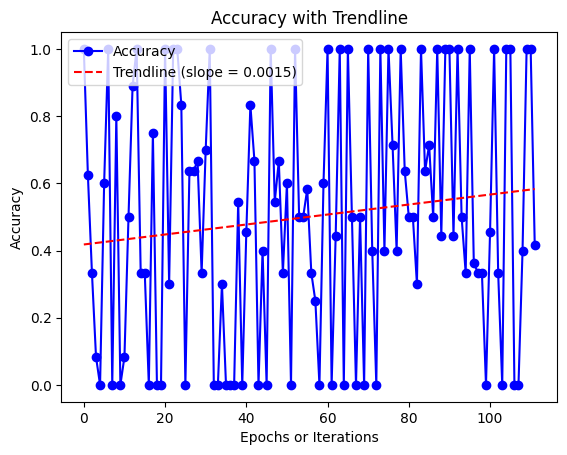

In [199]:

# Generate an array of indices (x-values)
x = np.arange(len(accuracies))

# Create a plot of the accuracies
plt.plot(x, accuracies, label='Accuracy', color='blue', marker='o')

# Calculate the trendline (slope) using polyfit (1st degree polynomial = line)
slope, intercept = np.polyfit(x, accuracies, 1)

# Generate the trendline y-values using the calculated slope and intercept
trendline = slope * x + intercept

# Plot the trendline
plt.plot(x, trendline, label=f'Trendline (slope = {slope:.4f})', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Epochs or Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy with Trendline')

# Display the legend
plt.legend()

# Show the plot
plt.show()


In [200]:
y_pred = test_with_predictions['predictions']

In [201]:
y_pred_labels = label_encoder.inverse_transform(test_with_predictions['predictions'])
y_test_labels = label_encoder.inverse_transform(test_with_predictions['label'])

In [202]:

print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           A       0.44      0.49      0.46       177
           D       0.40      0.03      0.06       129
           H       0.52      0.74      0.61       246

    accuracy                           0.49       552
   macro avg       0.45      0.42      0.38       552
weighted avg       0.47      0.49      0.43       552



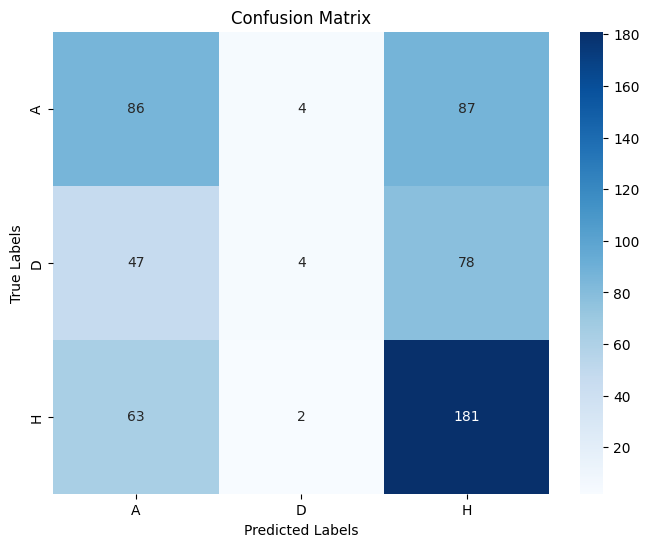

In [203]:
# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plotting the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
xlabel=ylabel=label_encoder.inverse_transform(model.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=xlabel, yticklabels=ylabel)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [204]:
# Get feature importances
feature_importances = model.feature_importances_


feature_names = train_columns  # If you're using a DataFrame for X_train
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

importance_df


,Feature,Importance
5,MaxH,0.078165
9,MaxA,0.060653
4,B365A,0.058073
6,AvgH,0.045143
10,AvgA,0.043821
2,B365H,0.031795
7,MaxD,0.017411
21,diff.total.shots_target,0.015776
48,diff.total.loss.whenHorA,0.015760
8,AvgD,0.015571


### My Results

In [205]:
test_with_predictions = pd.concat(test_batches_with_predictions, axis=0)

In [206]:
test[['predictions','proba_A','proba_D','proba_H']] = test_with_predictions[['predictions','proba_A','proba_D','proba_H']].values

In [207]:
my_predictions=test.sort_index()[['predictions','proba_A','proba_D','proba_H']]
my_predictions['predictions']=label_encoder.inverse_transform(my_predictions['predictions'].astype(int))

In [208]:
myresults=pd.concat([my_test_set, my_predictions ,], axis=1)

In [209]:
myresults=myresults[['Date','HomeTeam','AwayTeam', 'FTR', 'season', 'B365H', 'B365D', 'B365A','MaxH', 'AvgH', 'MaxD', 'AvgD', 'MaxA',
       'AvgA','predictions', 'proba_H', 'proba_D', 'proba_A']]

In [210]:
myresults.to_pickle('data/match_predictions.pkl')

In [211]:
myresults

,Date,HomeTeam,AwayTeam,FTR,season,B365H,B365D,B365A,MaxH,AvgH,MaxD,AvgD,MaxA,AvgA,predictions,proba_H,proba_D,proba_A
7728,2023-08-04,Sheffield Weds,Southampton,A,season23,3.10,3.4,2.30,3.31,3.14,3.47,3.38,2.35,2.28,A,0.382851,0.228971,0.388178
7729,2023-08-05,Blackburn,West Brom,H,season23,2.75,3.3,2.60,2.92,2.78,3.30,3.21,2.72,2.62,H,0.370586,0.286758,0.342655
7730,2023-08-05,Bristol City,Preston,D,season23,2.05,3.5,3.60,2.15,2.08,3.50,3.39,3.72,3.63,H,0.459704,0.287815,0.252481
7731,2023-08-05,Middlesbrough,Millwall,A,season23,1.91,3.3,4.33,2.05,1.95,3.60,3.47,4.33,3.97,H,0.466858,0.316061,0.217081
7732,2023-08-05,Norwich,Hull,H,season23,1.75,3.5,5.00,1.82,1.77,3.75,3.65,5.00,4.65,H,0.547513,0.264961,0.187526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,2024-05-04,Rotherham,Cardiff,H,season23,3.40,3.4,2.20,3.50,3.40,3.45,3.35,2.23,2.16,A,0.313730,0.243821,0.442449
8276,2024-05-04,Stoke,Bristol City,H,season23,2.05,3.4,3.75,2.10,2.05,3.70,3.52,3.75,3.51,H,0.430321,0.281037,0.288642
8277,2024-05-04,Sunderland,Sheffield Weds,A,season23,2.70,3.4,2.55,2.87,2.73,3.40,3.25,2.80,2.62,D,0.299973,0.352832,0.347195
8278,2024-05-04,Swansea,Millwall,A,season23,2.05,3.5,3.60,2.07,2.04,3.61,3.50,3.76,3.57,H,0.432750,0.287685,0.279565


In [212]:
myresults

,Date,HomeTeam,AwayTeam,FTR,season,B365H,B365D,B365A,MaxH,AvgH,MaxD,AvgD,MaxA,AvgA,predictions,proba_H,proba_D,proba_A
7728,2023-08-04,Sheffield Weds,Southampton,A,season23,3.10,3.4,2.30,3.31,3.14,3.47,3.38,2.35,2.28,A,0.382851,0.228971,0.388178
7729,2023-08-05,Blackburn,West Brom,H,season23,2.75,3.3,2.60,2.92,2.78,3.30,3.21,2.72,2.62,H,0.370586,0.286758,0.342655
7730,2023-08-05,Bristol City,Preston,D,season23,2.05,3.5,3.60,2.15,2.08,3.50,3.39,3.72,3.63,H,0.459704,0.287815,0.252481
7731,2023-08-05,Middlesbrough,Millwall,A,season23,1.91,3.3,4.33,2.05,1.95,3.60,3.47,4.33,3.97,H,0.466858,0.316061,0.217081
7732,2023-08-05,Norwich,Hull,H,season23,1.75,3.5,5.00,1.82,1.77,3.75,3.65,5.00,4.65,H,0.547513,0.264961,0.187526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,2024-05-04,Rotherham,Cardiff,H,season23,3.40,3.4,2.20,3.50,3.40,3.45,3.35,2.23,2.16,A,0.313730,0.243821,0.442449
8276,2024-05-04,Stoke,Bristol City,H,season23,2.05,3.4,3.75,2.10,2.05,3.70,3.52,3.75,3.51,H,0.430321,0.281037,0.288642
8277,2024-05-04,Sunderland,Sheffield Weds,A,season23,2.70,3.4,2.55,2.87,2.73,3.40,3.25,2.80,2.62,D,0.299973,0.352832,0.347195
8278,2024-05-04,Swansea,Millwall,A,season23,2.05,3.5,3.60,2.07,2.04,3.61,3.50,3.76,3.57,H,0.432750,0.287685,0.279565


In [213]:
myresults[myresults['Date']=='2023-08-12']

,Date,HomeTeam,AwayTeam,FTR,season,B365H,B365D,B365A,MaxH,AvgH,MaxD,AvgD,MaxA,AvgA,predictions,proba_H,proba_D,proba_A
7740,2023-08-12,Coventry,Middlesbrough,H,season23,2.38,3.30,3.00,2.50,2.41,3.47,3.36,3.04,2.92,A,0.348993,0.300803,0.350203
7741,2023-08-12,Birmingham,Leeds,H,season23,3.30,3.50,2.15,3.43,3.21,3.84,3.55,2.27,2.16,A,0.302740,0.198871,0.498388
7742,2023-08-12,Cardiff,QPR,A,season23,1.95,3.60,3.75,2.07,1.97,3.60,3.47,4.01,3.80,H,0.456920,0.263241,0.279838
7743,2023-08-12,Huddersfield,Leicester,A,season23,4.33,4.00,1.73,4.90,4.47,4.00,3.84,1.79,1.74,D,0.216246,0.462719,0.321036
7744,2023-08-12,Hull,Sheffield Weds,H,season23,2.25,3.40,3.20,2.38,2.30,3.47,3.35,3.20,3.07,H,0.427091,0.285716,0.287193
7745,2023-08-12,Ipswich,Stoke,H,season23,2.10,3.60,3.40,2.17,2.12,3.63,3.50,3.50,3.35,A,0.327599,0.320281,0.352120
7746,2023-08-12,Millwall,Bristol City,A,season23,1.83,3.60,4.33,1.97,1.88,3.75,3.53,4.45,4.17,H,0.548760,0.229728,0.221512
7747,2023-08-12,Preston,Sunderland,H,season23,2.63,3.40,2.60,2.90,2.70,3.60,3.36,2.65,2.57,A,0.302414,0.320228,0.377358
7748,2023-08-12,Rotherham,Blackburn,D,season23,2.90,3.40,2.40,3.09,2.92,3.66,3.37,2.45,2.40,A,0.328191,0.311301,0.360509
7749,2023-08-12,Southampton,Norwich,D,season23,1.83,3.75,4.00,1.91,1.84,3.93,3.69,4.40,4.13,H,0.503057,0.270773,0.226171


In [215]:
myresults[myresults['Date']=='2023-09-02']

,Date,HomeTeam,AwayTeam,FTR,season,B365H,B365D,B365A,MaxH,AvgH,MaxD,AvgD,MaxA,AvgA,predictions,proba_H,proba_D,proba_A
7776,2023-09-02,Birmingham,Millwall,D,season23,2.30,3.2,3.25,2.49,2.39,3.21,3.15,3.25,3.14,H,0.439220,0.271551,0.289229
7777,2023-09-02,Sunderland,Southampton,H,season23,2.80,3.6,2.40,2.90,2.78,3.70,3.54,2.49,2.43,A,0.336683,0.320938,0.342380
7778,2023-09-02,Swansea,Bristol City,A,season23,2.10,3.4,3.50,2.18,2.11,3.64,3.52,3.50,3.38,H,0.394601,0.329678,0.275721
7779,2023-09-02,Coventry,Watford,D,season23,2.10,3.5,3.40,2.18,2.14,3.65,3.49,3.44,3.33,H,0.421210,0.306802,0.271988
7780,2023-09-02,Ipswich,Cardiff,H,season23,1.62,4.2,5.50,1.70,1.64,4.20,4.07,5.50,5.01,H,0.561134,0.271037,0.167829
7781,2023-09-02,Leeds,Sheffield Weds,D,season23,1.44,4.5,7.50,1.48,1.44,5.10,4.71,7.50,6.84,H,0.528350,0.304908,0.166742
7782,2023-09-02,Leicester,Hull,A,season23,1.57,4.2,5.50,1.57,1.53,4.70,4.44,6.00,5.70,H,0.597854,0.233890,0.168256
7783,2023-09-02,Middlesbrough,QPR,A,season23,1.60,4.0,5.50,1.66,1.60,4.43,4.20,5.75,5.26,H,0.640656,0.233629,0.125715
7784,2023-09-02,Plymouth,Blackburn,H,season23,2.70,3.6,2.50,2.75,2.69,3.84,3.67,2.52,2.44,A,0.332476,0.269296,0.398228
7785,2023-09-02,Rotherham,Norwich,H,season23,4.50,3.8,1.75,4.90,4.50,4.00,3.90,1.79,1.74,A,0.212122,0.247224,0.540654


In [214]:
myresults[myresults['Date']=='2023-09-16']

,Date,HomeTeam,AwayTeam,FTR,season,B365H,B365D,B365A,MaxH,AvgH,MaxD,AvgD,MaxA,AvgA,predictions,proba_H,proba_D,proba_A
7790,2023-09-16,Blackburn,Middlesbrough,H,season23,2.63,3.25,2.75,2.63,2.51,3.66,3.52,2.79,2.69,H,0.339224,0.327962,0.332814
7791,2023-09-16,Bristol City,West Brom,D,season23,2.45,3.30,2.88,2.49,2.42,3.46,3.37,3.05,2.90,H,0.372585,0.278431,0.348984
7792,2023-09-16,Huddersfield,Rotherham,H,season23,1.85,3.40,4.33,1.91,1.88,3.70,3.56,4.44,4.14,H,0.512624,0.303862,0.183514
7793,2023-09-16,Norwich,Stoke,H,season23,1.91,3.50,4.20,1.92,1.89,3.92,3.70,4.20,3.92,H,0.450376,0.265542,0.284082
7794,2023-09-16,Preston,Plymouth,H,season23,1.95,3.60,3.75,2.02,1.98,3.71,3.57,3.89,3.69,H,0.408139,0.348293,0.243569
7795,2023-09-16,QPR,Sunderland,A,season23,3.10,3.50,2.25,3.37,3.20,3.70,3.52,2.25,2.19,A,0.218954,0.214626,0.566420
7796,2023-09-16,Sheffield Weds,Ipswich,A,season23,3.80,3.50,2.00,3.96,3.73,3.68,3.53,2.05,1.99,A,0.228307,0.294675,0.477019
7797,2023-09-16,Watford,Birmingham,H,season23,1.95,3.30,4.00,2.05,1.99,3.57,3.44,4.10,3.81,H,0.436430,0.344502,0.219069
7798,2023-09-16,Cardiff,Swansea,H,season23,2.55,3.25,2.80,2.66,2.54,3.44,3.34,2.85,2.76,H,0.375379,0.278905,0.345716


testing something

In [216]:
seasons_df

,Date,FTR,home.matchNumber,away.matchNumber,season,B365H,B365D,B365A,MaxH,AvgH,MaxD,AvgD,MaxA,AvgA,diff.daysSince,diff.total.win,diff.total.draw,diff.total.loss,diff.total.goals,diff.total.conceded,diff.total.half_goals,diff.total.half_conceded,diff.total.shots,diff.total.shots_against,diff.total.shots_target,diff.total.shots_against_target,diff.total.corners,diff.total.corners_conceded,diff.total.fouls,diff.total.fouls_other_team,diff.total.yellows,diff.total.reds,diff.last3.win,diff.last3.draw,diff.last3.loss,diff.last3.goals,diff.last3.conceded,diff.last3.half_goals,diff.last3.half_conceded,diff.last3.shots,diff.last3.shots_against,diff.last3.shots_target,diff.last3.shots_against_target,diff.last3.corners,diff.last3.corners_conceded,diff.last3.fouls,diff.last3.fouls_other_team,diff.last3.yellows,diff.last3.reds,diff.total.win.whenHorA,diff.total.draw.whenHorA,diff.total.loss.whenHorA,diff.grade,diff.grade2,diff.Balance,diff.TotArrivals,label
0,2009-08-07,D,1,1,season09,2.25,3.25,3.20,2.43,2.23,3.40,3.21,3.50,3.13,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16.0,-29980000.0,-3,1
1,2009-08-08,H,1,1,season09,1.67,3.60,5.25,1.73,1.66,3.81,3.48,5.61,5.08,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,11.0,585000.0,2,2
2,2009-08-08,D,1,1,season09,1.91,3.30,4.20,1.97,1.88,3.46,3.29,4.48,3.99,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,5.0,-25000.0,8,1
3,2009-08-08,H,1,1,season09,2.00,3.30,3.80,2.10,1.97,3.42,3.27,4.00,3.67,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,50.0,-2910000.0,-5,2
4,2009-08-08,H,1,1,season09,2.25,3.25,3.20,2.30,2.21,3.31,3.22,3.53,3.10,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-17,3.0,1385000.0,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,2024-05-04,H,46,46,season23,3.40,3.40,2.20,3.50,3.40,3.45,3.35,2.23,2.16,0.0,-0.333333,0.155556,0.177778,-0.422222,0.488889,-0.222222,0.288889,-2.711111,2.8,-1.511111,1.688889,-0.822222,1.866667,1.777778,-0.933333,0.0,0.066667,-0.333333,0.333333,0.0,-1.333333,-1.666667,-0.333333,-1.0,-4.333333,-4.333333,-3.0,-3.0,-0.666667,3.333333,3.0,-0.666667,2.0,0.0,-0.227273,0.272727,-0.045455,2,-8.0,930000.0,-8,2
8276,2024-05-04,H,46,46,season23,2.05,3.40,3.75,2.10,2.05,3.70,3.52,3.75,3.51,0.0,-0.066667,0.0,0.066667,-0.177778,0.288889,0.0,0.288889,0.688889,-0.577778,-0.2,0.177778,0.622222,-0.155556,2.866667,-0.711111,0.844444,0.044444,0.333333,-0.333333,0.0,0.333333,-0.333333,0.666667,0.0,3.666667,2.666667,0.333333,0.0,-2.0,1.333333,9.0,-5.666667,1.333333,0.0,0.045455,-0.045455,0.0,-2,3.0,31540000.0,7,2
8277,2024-05-04,A,46,46,season23,2.70,3.40,2.55,2.87,2.73,3.40,3.25,2.80,2.62,0.0,0.044444,0.0,-0.044444,0.222222,-0.355556,0.177778,-0.111111,3.244444,-1.644444,1.444444,-0.133333,0.688889,-0.755556,-2.044444,2.822222,-0.177778,-0.066667,-0.333333,-0.333333,0.666667,-2.0,0.0,-0.333333,-0.333333,-2.0,-5.333333,-1.666667,-2.0,1.0,-3.666667,1.333333,0.0,0.0,0.0,0.181818,0.045455,-0.227273,21,-1.0,-3090000.0,-3,0
8278,2024-05-04,A,46,46,season23,2.05,3.50,3.60,2.07,2.04,3.61,3.50,3.76,3.57,0.0,0.0,0.022222,-0.022222,0.333333,0.2,0.111111,0.111111,1.044444,1.177778,0.266667,0.933333,0.911111,-0.711111,-2.466667,2.844444,-0.288889,0.044444,-0.333333,0.333333,0.0,0.666667,0.333333,-0.333333,0.333333,6.0,3.666667,2.0,0.0,2.0,-2.666667,-0.333333,3.666667,0.333333,0.0,0.090909,-0.045455,-0.045455,-2,-6.0,-18240000.0,-3,0


In [217]:

conditions = [
    (seasons_df['B365H'] < seasons_df['B365D']) & (seasons_df['B365H'] < seasons_df['B365A']),
    (seasons_df['B365A'] < seasons_df['B365H']) & (seasons_df['B365A'] < seasons_df['B365D'])
]

choices = ['H', 'A']  # Assuming 'H' means home win and 'A' means away win

seasons_df['bet_result'] = np.select(conditions, choices, default='D')


In [220]:
my_season=seasons_df[seasons_df['season']=='season09'].copy()

In [223]:
(my_season['FTR']==my_season['bet_result']).value_counts()

False    292
True     260
Name: count, dtype: int64

In [225]:
(my_season['FTR']==my_season['bet_result']).mean()

0.47101449275362317

In [226]:
(my_season['FTR']==my_season['bet_result']).value_counts(normalize=True)

False    0.528986
True     0.471014
Name: proportion, dtype: float64